# US Mass Shootings Analysis

<a id="top"></a>
## Are mass shootings getting worse?
- [High Level Trends](#High-Level-Trends)
- Mass shooting casualties are increasing over time.  This is a result of more frequent mass shootings, and not beecause of more severe mass shootings (despite the recent Las Vegas shooting).
- It does not appear that mass shootings are becoming more deadly, the ratio of deaths to casualties is randomly distributed


## Do demographics correlate to shooters in mass shootings?
### Age
- [Age Analysis](#Age-Analysis)
- The population is segmented at 50.  After age 50 the the number of shootings drops precipitously.  Under 50 the number of incidents are evenly distributed.
- 20-29 y.o. have more severe attacks than any other age group. (excluding 2017 Vegas)
- Over time there is not a clear pattern for any one age group to say that they are different from the aggregate trend
- Since 2005, the periods that have the most data points, there is an increasing trend in the average age of shooters.
- 2015-current has the most incidents, but there is a large percentage of age unknown in this period

### Race
- [Race Analysis](#Race-Analysis)
- The majority of shooters whose race is known are white
- When excluding Las Vegas incident (outlier), Other Race has the highest casualties per incident at ~16

### Gender
- [Gender Analysis](#Gender-Analysis)
- Males are responsible for 292/297 mass shootings

## Data notes
- Time series data is considered on a 5 year basis to smoothe curves, and give a higher level of data points in each period
- Data was cleaned to consolidate multiple naming conventions
- Null values are ignored

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline
plt.style.use('seaborn-darkgrid')

In [2]:
## open csv in sublime save as utf8 encoded

df = pd.read_csv('/Users/mba/projects/mass_shootings/mass_shootings.csv', encoding = 'utf8')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323 entries, 0 to 322
Data columns (total 21 columns):
S#                      323 non-null int64
Title                   323 non-null object
Location                278 non-null object
Date                    323 non-null object
Incident Area           261 non-null object
Open/Close Location     295 non-null object
Target                  318 non-null object
Cause                   246 non-null object
Summary                 323 non-null object
Fatalities              323 non-null int64
Injured                 323 non-null int64
Total victims           323 non-null int64
Policeman Killed        317 non-null float64
Age                     179 non-null object
Employeed (Y/N)         67 non-null float64
Employed at             41 non-null object
Mental Health Issues    323 non-null object
Race                    321 non-null object
Gender                  323 non-null object
Latitude                303 non-null float64
Longitude         

In [4]:
pd.options.display.max_columns = 50
df.head(5)

,S#,Title,Location,Date,Incident Area,Open/Close Location,Target,Cause,Summary,Fatalities,Injured,Total victims,Policeman Killed,Age,Employeed (Y/N),Employed at,Mental Health Issues,Race,Gender,Latitude,Longitude
0,1,Texas church mass shooting,"Sutherland Springs, TX",11/5/2017,Church,Close,random,unknown,"Devin Patrick Kelley, 26, an ex-air force offi...",26,20,46,0.0,26,NaN,NaN,No,White,M,NaN,NaN
1,2,Walmart shooting in suburban Denver,"Thornton, CO",11/1/2017,Wal-Mart,Open,random,unknown,"Scott Allen Ostrem, 47, walked into a Walmart ...",3,0,3,0.0,47,NaN,NaN,No,White,M,NaN,NaN
2,3,Edgewood businees park shooting,"Edgewood, MD",10/18/2017,Remodeling Store,Close,coworkers,unknown,"Radee Labeeb Prince, 37, fatally shot three pe...",3,3,6,0.0,37,NaN,Advance Granite Store,No,Black,M,NaN,NaN
3,4,Las Vegas Strip mass shooting,"Las Vegas, NV",10/1/2017,Las Vegas Strip Concert outside Mandala Bay,Open,random,unknown,"Stephen Craig Paddock, opened fire from the 32...",59,527,585,1.0,64,NaN,NaN,Unclear,White,M,36.181271,-115.134132
4,5,San Francisco UPS shooting,"San Francisco, CA",6/14/2017,UPS facility,Close,coworkers,NaN,"Jimmy Lam, 38, fatally shot three coworkers an...",3,2,5,0.0,38,1.0,NaN,Yes,Asian,M,NaN,NaN


## Data Perparation

In [6]:
## rename all cols to lower case, and replace ' ' with '_'

cols = df.columns.tolist()
cols_rn = [col.lower().replace(' ', '_') for col in cols]
cols = zip(cols, cols_rn)
mydict = {}
for col in cols:
    mydict[col[0]] = col[1]
df.rename(columns=mydict, inplace=True)

In [7]:
## change data to date time and create a 'year' feature
## rename columns

df['date'] = pd.to_datetime(df['date'])
df['year'] = df.loc[:, 'date'].apply(lambda x: x.year)
df.rename(columns={'s#':'incident_ct', 
                   'total_victims': 'total_casualties',
                   'employeed_(y/n)':'employed'
                  }, inplace=True)
df.age.fillna('0', inplace=True)

In [8]:
## 5 year grouping feature

df['year_5'] = df['year'].apply(lambda x: x - 1965)
df['year_5'] = df['year_5'].apply(lambda x: (x // 5))
df['year_5'] = df['year_5'].apply(lambda x: (x * 5) + 1965)

In [9]:
## clean age feature
## bad entries have multiple ages for multiple shooters, took last in list for oldest

def age_clean(x):
    y = re.search(r'(\d+),', x)
    if y:
        return int(x.split(',')[-1])
    else:
        return int(x)
df['age'] = df['age'].apply(age_clean)

In [10]:
## 10 year age group feature, some Nan's and some bad entries

def age_group(x):
    if x == 0:
        return 0
    else :
        return x // 10 * 10
df['age_10'] = df['age'].apply(age_group)

In [11]:
## condense race descriptions into more concise list

df['race'].fillna('unknown', inplace=True)
df['race'] = df['race'].apply(lambda x: x.lower())
df.loc[df['race'] == 'some other race', 'race'] = 'other'
df.loc[df['race'] == 'black american or african american', 'race'] = 'black'
df.loc[df['race'] == 'white american or european american', 'race'] = 'white'
df.loc[df['race'] == 'asian american', 'race'] = 'asian'
df.loc[df['race'] == 'black american or african american/unknown', 'race'] = 'black'
df.loc[df['race'] == 'white american or european american/some other race', 'race'] = 'white'
df.loc[df['race'] == 'asian american/some other race', 'race'] = 'asian'

In [12]:
df['gender'].unique().tolist()

['M', 'Unknown', 'Male', 'M/F', 'Male/Female', 'Female']

In [13]:
## clean gender feature

df.loc[df['gender'] == 'M', 'gender'] = 'Male'
df.loc[df['gender'] == 'M/F', 'gender'] = 'Male/Female'

In [14]:
## create df_year_5

df_year_5 = df.groupby('year_5', as_index=False).agg({'fatalities': 'sum', 'injured': 'sum', 
                                                    'total_casualties': 'sum', 'incident_ct': 'count'})
df_year_5['casualties_per_incident'] = df_year_5.loc[:, ['total_casualties', 'incident_ct']].apply(
                                                    lambda x: x[0] / x[1], axis=1)

## High Level Trends
[top](#top)

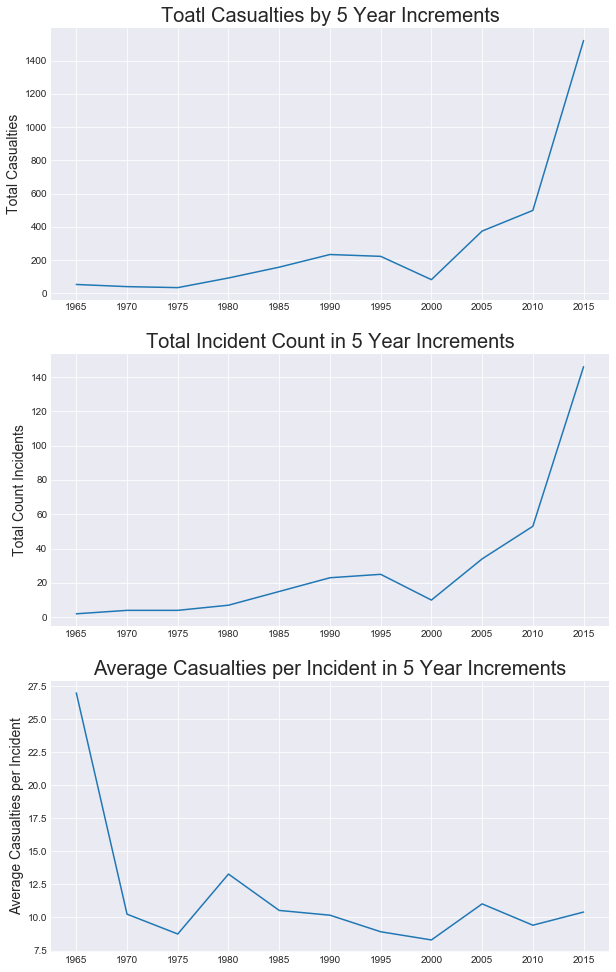

In [15]:
## charts by year for total casualties, number of incidents, and average casualties per incident

dims = (10,17)
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=dims)
plt.setp(axes, xticks=np.arange(min(df_year_5['year_5']), max(df_year_5['year_5']) + 5, 5))



axes[0].plot(df_year_5['year_5'], df_year_5['total_casualties'])
axes[0].set_ylabel('Total Casualties', fontsize=14)
axes[0].set_title('Toatl Casualties by 5 Year Increments', fontsize=20)

axes[1].plot(df_year_5['year_5'], df_year_5['incident_ct']);
axes[1].set_ylabel('Total Count Incidents', fontsize = 14)
axes[1].set_title('Total Incident Count in 5 Year Increments', fontsize = 20);


axes[2].plot(df_year_5['year_5'], df_year_5['casualties_per_incident']);
axes[2].set_ylabel('Average Casualties per Incident', fontsize = 14)
axes[2].set_title('Average Casualties per Incident in 5 Year Increments', fontsize = 20);

In [16]:
## look at deaths as a percent of casualties

df_year_5['death_pct'] = df_year_5[['fatalities', 'total_casualties']].apply(lambda x: x[0] / x[1], axis=1)

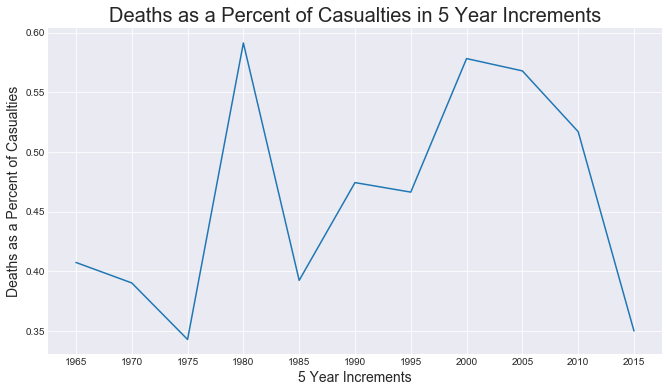

In [17]:
## chart to show if there is any pattern of increases in fatalities over time

dims = (11, 6)
fig, ax = plt.subplots(figsize=dims)

plt.plot(df_year_5['year_5'], df_year_5['death_pct']);
ax.set_xlabel('5 Year Increments', fontsize = 14)
ax.set_ylabel('Deaths as a Percent of Casualties', fontsize = 14)
ax.set_title('Deaths as a Percent of Casualties in 5 Year Increments', fontsize = 20);
plt.xticks(np.arange(min(df_year_5['year_5']), max(df_year_5['year_5']) + 5, 5));

## Set up for demographic analysis

In [18]:
## set up table to show age graphic charts
## age, gender, race

df.head()
df_demo = df.groupby(['year_5', 'age_10', 'gender', 'race']).agg({
    'fatalities':sum,
    'total_casualties':sum,
    'incident_ct':'count'  
}).sort_index()
df_demo.reset_index(inplace=True)
df_demo['casualties_per_incident'] = df_demo.loc[:, ['total_casualties', 'incident_ct']].apply(
                                                    lambda x: x[0] / x[1], axis=1)

## Age Analysis
[top](#top)

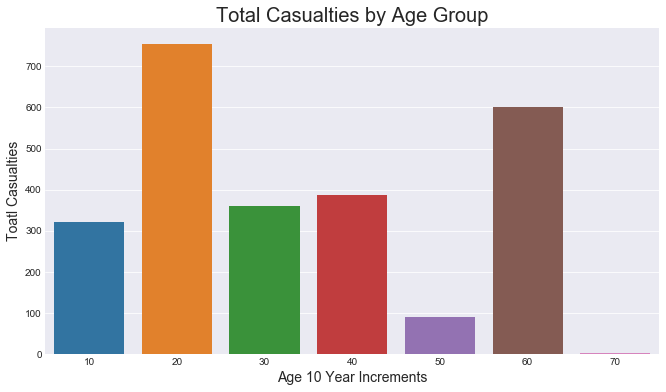

In [19]:
dims = (11, 6)
fix, ax = plt.subplots(figsize=dims)


sns.barplot(x='age_10', y='total_casualties', data=df_demo[df_demo['age_10'] != 0], estimator=sum, ci=None);
ax.set_xlabel('Age 10 Year Increments', fontsize = 14)
ax.set_ylabel('Toatl Casualties', fontsize = 14)
ax.set_title('Total Casualties by Age Group', fontsize = 20);

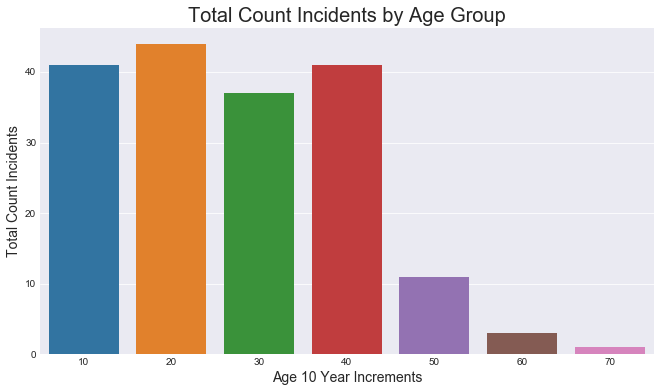

In [20]:
dims = (11, 6)
fix, ax = plt.subplots(figsize=dims)

sns.barplot(x='age_10', y='incident_ct', data=df_demo[df_demo['age_10'] != 0], estimator=sum, ci=None);
ax.set_xlabel('Age 10 Year Increments', fontsize = 14)
ax.set_ylabel('Total Count Incidents', fontsize = 14)
ax.set_title('Total Count Incidents by Age Group', fontsize = 20);

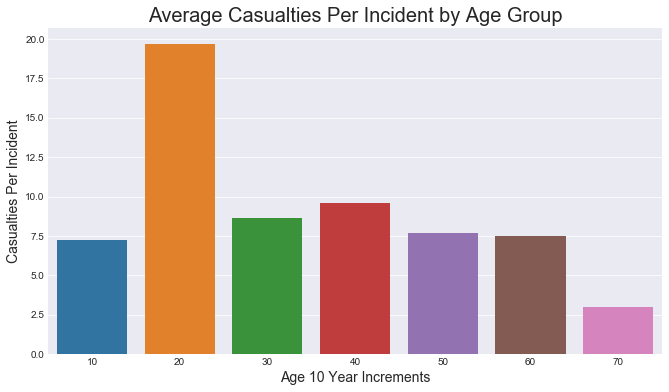

In [21]:
## excluded the 2017 shooting with ~600 casualties because it is an outlier and was
## mudying the data for 60 bc there are only 3 incidents for that age group.

dims = (11, 6)
fix, ax = plt.subplots(figsize=dims)

sns.barplot(x='age_10', 
            y='casualties_per_incident', 
            data=df_demo[(df_demo['age_10'] != 0) & (df_demo['total_casualties'] < 200)], 
            estimator=np.mean, 
            ci=None)
ax.set_xlabel('Age 10 Year Increments', fontsize = 14)
ax.set_ylabel('Casualties Per Incident', fontsize = 14)
ax.set_title('Average Casualties Per Incident by Age Group', fontsize = 20);

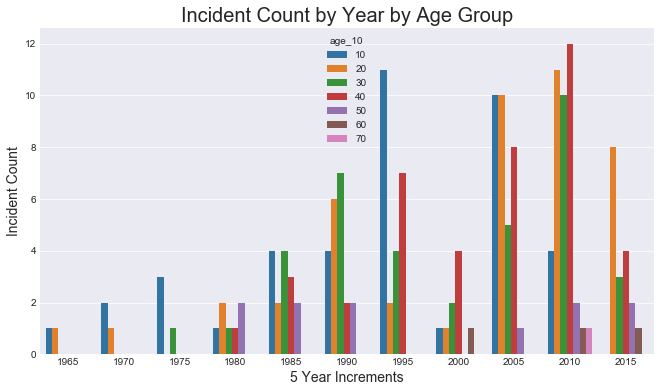

In [22]:
dims = (11, 6)
fix, ax = plt.subplots(figsize=dims)

sns.barplot(x='year_5', y='incident_ct', hue='age_10',
            data=df_demo[df_demo['age_10'] != 0], 
            estimator=sum, ci=None);
ax.set_xlabel('5 Year Increments', fontsize = 14)
ax.set_ylabel('Incident Count', fontsize = 14)
ax.set_title('Incident Count by Year by Age Group', fontsize = 20);

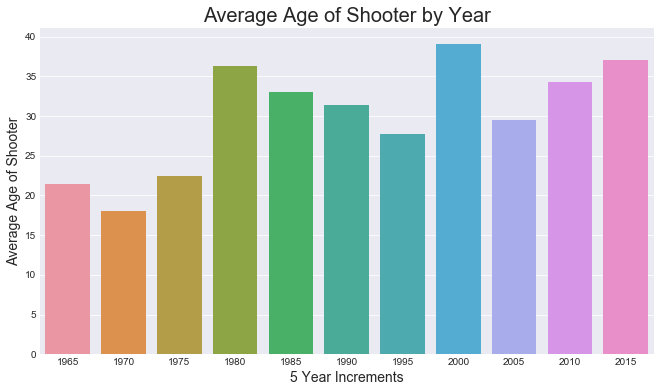

In [23]:
dims = (11, 6)
fix, ax = plt.subplots(figsize=dims)

sns.barplot(x='year_5', y='age',
            data=df[df['age_10'] != 0], 
            estimator=np.mean, ci=None);
ax.set_xlabel('5 Year Increments', fontsize = 14)
ax.set_ylabel('Average Age of Shooter', fontsize = 14)
ax.set_title('Average Age of Shooter by Year', fontsize = 20);

In [24]:
## Check what which year the unknown ages come from

def age_test(x):
    if x == 0:
        return 'n/a'
    else:
        return 'age'
df_demo_test = df[['age_10', 'year_5']].copy()
df_demo_test['no_age'] = df_demo_test['age_10'].apply(age_test)

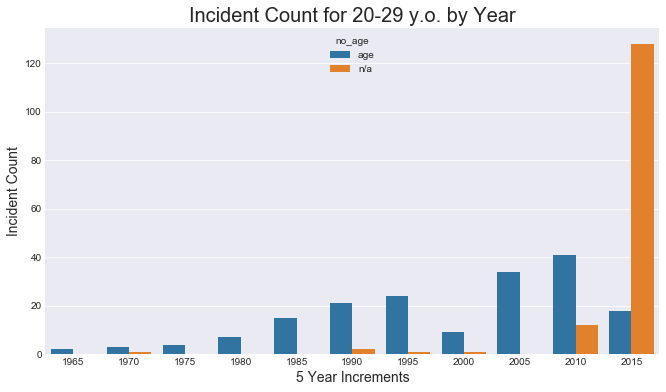

In [25]:
dims = (11, 6)
fix, ax = plt.subplots(figsize=dims)

sns.countplot(x='year_5', hue='no_age',
            data=df_demo_test);
ax.set_xlabel('5 Year Increments', fontsize = 14)
ax.set_ylabel('Incident Count', fontsize = 14)
ax.set_title('Incident Count for 20-29 y.o. by Year', fontsize = 20);

In [26]:
df.loc[df['year_5'] <= 1970, ['year', 'year_5', 'age', 'fatalities', 'total_casualties', 'incident_ct']]

,year,year_5,age,fatalities,total_casualties,incident_ct
317,1974,1970,17,3,10,318
318,1974,1970,14,1,4,319
319,1972,1970,23,10,22,320
320,1971,1970,0,2,5,321
321,1966,1965,18,5,6,322
322,1966,1965,25,17,48,323


## Race Analysis
[top](#top)

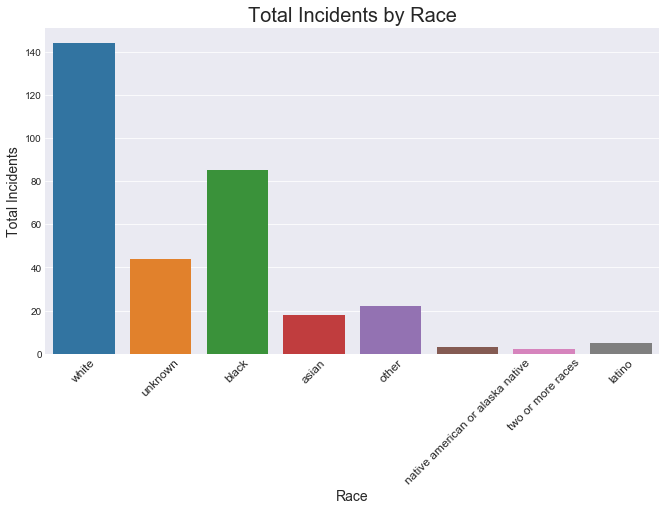

In [27]:
dims = (11, 6)
fix, ax = plt.subplots(figsize=dims)

sns.barplot(x='race', y='incident_ct', data=df_demo, estimator=sum, ci=None);
ax.set_xlabel('Race', fontsize = 14)
ax.set_ylabel('Total Incidents', fontsize = 14)
ax.set_title('Total Incidents by Race', fontsize = 20);
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_fontsize(12)

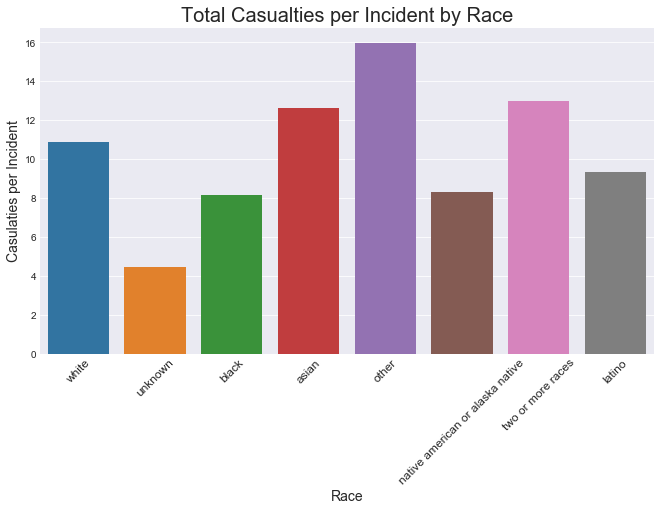

In [28]:
dims = (11, 6)
fix, ax = plt.subplots(figsize=dims)

sns.barplot(x='race', y='casualties_per_incident', 
            data=df_demo[(df_demo['total_casualties'] < 500)], 
            estimator=np.mean, ci=None);
ax.set_xlabel('Race', fontsize = 14)
ax.set_ylabel('Casulaties per Incident', fontsize = 14)
ax.set_title('Total Casualties per Incident by Race', fontsize = 20);
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_fontsize(12)

## Gender Analysis
[top](#top)

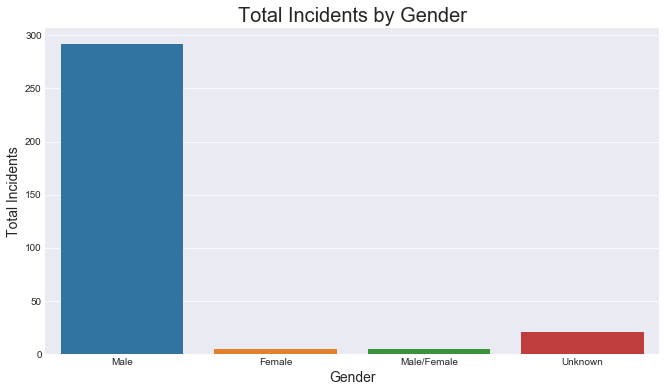

In [29]:
dims = (11, 6)
fix, ax = plt.subplots(figsize=dims)

sns.barplot(x='gender', y='incident_ct', data=df_demo, estimator=sum, ci=None);
ax.set_xlabel('Gender', fontsize = 14)
ax.set_ylabel('Total Incidents', fontsize = 14)
ax.set_title('Total Incidents by Gender', fontsize = 20);